# Data downloading

In [0]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q /content/drive/My\ Drive/results_max_wt.zip
!unzip -q /content/drive/My\ Drive/wt_cropped_data_720x720.zip
!unzip -q /content/drive/My\ Drive/wt_cropped_gt_720x720.zip
!unzip -q /content/drive/My\ Drive/test_data_720x720.zip

!mkdir ./test_gt
!mv ./test_data_720x720/*_gt.png ./test_gt/

!mv test_data_720x720/ test_data 

!mkdir results_max_wt
!mv /content/content/results_max_wt/* ./results_max_wt/

!rm -r content

!mkdir cropped_data
!mv /content/wt_cropped_data_720x720/wt_cropped_data_720x720/content/cropped_data_720x720/* ./cropped_data

!mkdir cropped_gt
!mv /content/wt_cropped_gt_720x720/content/cropped_gt_720x720/* ./cropped_gt

!rm -r wt_cropped_data_720x720
!rm -r wt_cropped_gt_720x720

In [0]:
!unzip -q /content/drive/My\ Drive/cropped_mask.zip
!unzip -q /content/drive/My\ Drive/test_mask.zip

In [0]:
!unzip -q /content/drive/My\ Drive/ifcnn_data.zip
!unzip -q /content/drive/My\ Drive/ifcnn_mask.zip
!unzip -q /content/drive/My\ Drive/ifcnn_target.zip

In [0]:
import os
from collections import Counter

def get_idx_and_num_samples(root):
    data = [int(file.split("_")[0]) for files in os.walk(root) for file in files[2]]
    counter = dict(Counter(data))

    n = [key for key, _ in counter.items()]
    count = [value for _, value in counter.items()]

    return n, count

In [0]:
# get indexes and number of samples for each example

root = '/content/cropped_data'
n, count = get_idx_and_num_samples(root)
root = '/content/test_data'
n_val, count_val = get_idx_and_num_samples(root)
root = '/content/ifcnn_data'
n_test, count_test = get_idx_and_num_samples(root)

# Generator model

In [0]:
### ================== GENERATOR============================ ####

import torch.nn.functional as F
from torch import nn
import torch
import torch.optim as optim


class DenseBlock(nn.Module):
    """
    DenseNet
    """
    def __init__(self,channels,beta = 0.5):
        super(DenseBlock, self).__init__()
        self.beta = beta
        self.conv_module1 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module2 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module3 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.conv_module4 = nn.Sequential(
                nn.Conv2d(channels,channels, 3, 1, padding=1),
                nn.LeakyReLU(inplace=True)
                )
        self.last_conv = nn.Conv2d(channels, channels, 3, 1, padding = 1) 

    def forward(self, x): #three layer
        module1_out = self.conv_module1(x)
        module1_out_temp = x + module1_out
        module2_out = self.conv_module2(module1_out_temp)
        module2_out_temp = x + module1_out_temp + module2_out
        module4_out_temp = x + module1_out_temp + module2_out_temp
        last_conv = self.last_conv(module4_out_temp)
        out = x + last_conv * self.beta

        return out


class Generator(nn.Module):
    def __init__(self, in_c, out_c, residual_beta = 0.5):
        """
        in_c : input channels
        out_c: output channels
        """
        super(Generator, self).__init__()
        self.residual_beta = residual_beta

        self.inconv = nn.Sequential(
            nn.Conv2d(in_c, 64, 9, 1, padding=4),
            nn.PReLU()
        )
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(64, beta = residual_beta) for _ in range(2)])
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(128, beta = residual_beta) for _ in range(2)])

        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(256, beta = residual_beta) for _ in range(2)])
        )
        self.bottom = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1 ,padding = 1),
            nn.PReLU(),
            nn.Conv2d(512, 512, 3, stride = 1, padding = 1),
            nn.PReLU(),
            nn.Conv2d(512, 256, 3, 1, padding = 1),
            nn.PReLU()
        )
        self.up1 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(256 ,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.PReLU()
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(128,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.PReLU()
        )
        self.up3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding = 1),
            nn.PReLU(),
            nn.Sequential(*[DenseBlock(64,beta = residual_beta) for _ in range(2)]),
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.PReLU()
        )
        self.out = nn.Conv2d(64, out_c, 9, 1, padding = 4)

    def forward(self,x):
        cin = self.inconv(x)
        down1 = self.down1(cin)
        downsample1 = F.avg_pool2d(down1, kernel_size = 2, stride = 2)
        down2 = self.down2(downsample1)
        downsample2 = F.avg_pool2d(down2, kernel_size = 2, stride = 2)
        down3 = self.down3(downsample2)
        downsample3 = F.avg_pool2d(down3, kernel_size = 2, stride = 2)

        bottom = self.bottom(downsample3)

        upsample1 = F.interpolate(bottom, scale_factor = 2)

        cat1 = torch.cat([down3, upsample1], dim = 1)
        up1 = self.up1(cat1)
        upsample2 = F.interpolate(up1, scale_factor = 2)
        cat2 = torch.cat([down2, upsample2],dim = 1)
        up2 = self.up2(cat2)
        upsample3 = F.interpolate(up2, scale_factor = 2)
        cat3 = torch.cat([down1, upsample3], dim = 1)
        up3 = self.up3(cat3)
        out = self.out(up3)
        out = (torch.tanh(out) + 1) / 2

        return out

# Discriminator model

In [0]:
import torch.nn.functional as F
from torch import nn

class DiscriminatorPatch64(nn.Module):
    def __init__(self):
        super(DiscriminatorPatch64, self).__init__()
        self.net1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.net2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.net3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.net4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4)),

            nn.Conv2d(512, 1, kernel_size=1)
        )

    def forward(self, x):
        output1 = self.net1(x)
        output2 = self.net2(output1)
        output3 = self.net3(output2)
        output = self.net4(output3)
        output_shape = (output.size(0), output.size(2), output.size(3))
        final_output = torch.sigmoid(output.view(output_shape))
        
        return final_output, output1, output2, output3

# VGG16 model for perceptual loss

In [0]:
# import torch
# from torchvision import models


# class VGG_OUTPUT(object):

#     def __init__(self, relu1_2, relu2_2, relu3_3, relu4_3):
#         self.__dict__ = locals()


# class VGG16(torch.nn.Module):
#     def __init__(self, requires_grad=False):
#         super(VGG16, self).__init__()
#         vgg_pretrained_features = models.vgg16(pretrained=True).features
#         self.slice1 = torch.nn.Sequential()
#         self.slice2 = torch.nn.Sequential()
#         self.slice3 = torch.nn.Sequential()
#         self.slice4 = torch.nn.Sequential()
#         for x in range(4):
#             self.slice1.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(4, 9):
#             self.slice2.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(9, 16):
#             self.slice3.add_module(str(x), vgg_pretrained_features[x])
#         for x in range(16, 23):
#             self.slice4.add_module(str(x), vgg_pretrained_features[x])
#         if not requires_grad:
#             for param in self.parameters():
#                 param.requires_grad = False

#     def forward(self, X):
#         h = self.slice1(X)
#         h_relu1_2 = h
#         h = self.slice2(h)
#         h_relu2_2 = h
#         h = self.slice3(h)
#         h_relu3_3 = h
#         h = self.slice4(h)
#         h_relu4_3 = h
#         return VGG_OUTPUT(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)

# Dataset 

In [0]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Rotate, VerticalFlip, ShiftScaleRotate
from albumentations.pytorch import ToTensor


class microDataset(Dataset):
    def __init__(self, img_dir, gt_dir, mask_dir, n, count, max_count, transform=None, test_flag=False):
        self.count = count
        self.max_count = max_count
        self.n = n
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.mask_dir = mask_dir
        self.img = sorted(next(os.walk(self.img_dir))[2])
        self.gt = sorted(next(os.walk(self.gt_dir))[2])
        self.transform = transform
        self.real_mask = np.array(Image.open("/content/real_mask.png"))
        self.idx = (np.array(Image.open("/content/real_mask.png"))==0)
        self.test_flag = test_flag

    def __len__(self):
        return len(self.gt)
    
    def load_img(self,idx,number):
      try:
        img = np.array(Image.open(os.path.join(self.img_dir, f"{self.n[idx]}_{number}.png")))
      except:
        img = np.zeros((720,720,3))
      if self.test_flag == False:
         img[self.idx] = 0
  
      return img
    
    def load_mask(self,idx,number):
      try:
        mask = np.array(Image.open(os.path.join(self.mask_dir, f"{self.n[idx]}_{number}.png")))[:,:,None]
      except:
        mask = np.zeros((720,720,1))
      if self.test_flag == False:
          mask[self.idx] = 0
      return mask
    
    def __getitem__(self, idx):
        imgs = [self.load_img(idx,number+1) for number in range(self.max_count)] 
        masks = [self.load_mask(idx,number+1) for number in range(self.max_count)]        
        try:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"IFCNN-MAX-{self.n[idx]}.png"))
        except:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"{self.n[idx]}_gt.png"))
        res = []
        if self.transform:
            seed = np.random.randint(666)
            
            # Convert PIL image to numpy array



            gt_np = np.array(ground_truth)
            gt_np[self.idx] = 0
            for i in range(len(imgs)):
              random.seed(seed)
              img = imgs[i]
              aug = self.transform(image=img)
              res.append(aug['image'])
            for i in range(len(masks)):
              random.seed(seed)
              img = masks[i]
              aug = self.transform(image=img)
              res[i] = res[i] * aug['image']
              res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=gt_np)
            res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=self.real_mask[:,:,None])
            res.append(aug['image'])
            

        return [torch.cat(res[:self.max_count],dim=0),torch.cat(res[self.max_count:2*self.max_count]),res[-2],res[-1]]

In [0]:
albumentations_pil_transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=20, p=0.6),
    ToTensor()
])

albumentations_pil_transform_val = Compose([
    ToTensor()
])

train_dataset = microDataset('/content/cropped_data', '/content/results_max_wt',"/content/cropped_mask", n, count, max(count), transform=albumentations_pil_transform)
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True, pin_memory=True)
val_dataset = microDataset('/content/test_data', '/content/test_gt',"/content/test_mask", n_val, count_val, max(count), transform=albumentations_pil_transform_val)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=True, pin_memory=True)

test_dataset = microDataset('/content/ifcnn_data', '/content/ifcnn_target',"/content/ifcnn_mask", n_test, count_test, max(count), transform=albumentations_pil_transform_val, test_flag=True)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=True, pin_memory=True)

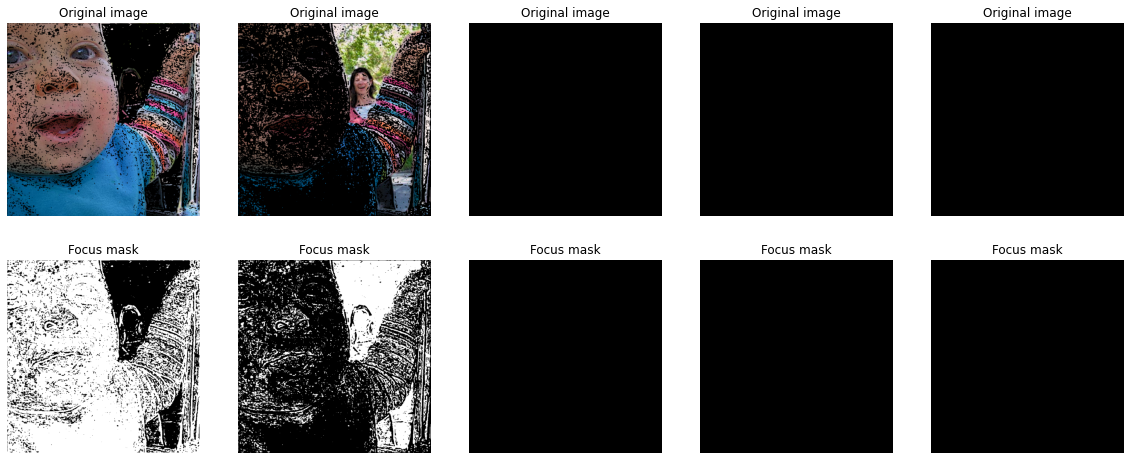

In [0]:
### algorithm for mask generation testing

plt.figure(figsize=(20,8))
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(obj[0][0][i*3:(i+1)*3].numpy().transpose(1,2,0))
  plt.axis('off')
  plt.title("Original image")
for i in range(5):
  plt.subplot(2,5,5+i+1)
  plt.imshow(obj[1][0][i].numpy(),cmap='gray')
  plt.axis('off')
  plt.title("Focus mask")

# Tensorboard

In [1]:
!wget -O utils.py https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
!pip install einops

%load_ext tensorboard
import os
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

--2020-06-06 12:21:01--  https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving drive.google.com (drive.google.com)... 108.177.126.138, 108.177.126.100, 108.177.126.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rjm0e86nucjb4jetn37ubavgu2i7p9b9/1591446000000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml [following]
--2020-06-06 12:21:02--  https://doc-0g-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rjm0e86nucjb4jetn37ubavgu2i7p9b9/1591446000000/11513719840956837432/*/1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
Resolving doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)... 74.125.128.132, 2a00:1450:4013:c02::84
Connecting to doc-0g-6g-docs.googleusercontent.com (doc-0g-6g-docs.googleusercontent.com)|74

<IPython.core.display.Javascript object>

# Training pipeline

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def gan_train(epochs, dataset, batch_size, optim_disc, optim_gen, discriminator, generator, scheduler_optim_discriminator, scheduler_optim_generator, exp_name = 'my GAN', flag_gp=False):
    
    writer = SummaryWriter(f'logs/{exp_name}')
    losses_D_hist = []
    losses_G_hist = []

    for epoch in range(epochs):
        # Train discriminator
        discriminator_running_loss = 0.0
        total = 0
        generator.train()
        for batch_idx, (imgs, masks, target, mask) in enumerate(train_dataloader):
            mask_torch = Variable(mask.to(device))
            imgs, masks, target = Variable(imgs.to(device)), Variable(masks.to(device)), Variable(target.to(device))

            optim_disc.zero_grad()
            total += batch_size
            fake_data = generator(imgs)
            fake_data *= mask_torch

            disc_loss = nn.BCELoss()(discriminator(target)[0], torch.ones(discriminator(target)[0].shape).cuda()) + nn.BCELoss()(discriminator(fake_data)[0], torch.zeros(discriminator(fake_data)[0].shape).cuda())
            
            discriminator_running_loss += disc_loss.item() * batch_size

            disc_loss.backward()
            optim_disc.step()


            # discriminator loss
            loss_discriminator = discriminator_running_loss / total
            losses_D_hist.append(loss_discriminator)

            # update generator
            optim_gen.zero_grad()
            
            fake_data = generator(imgs)*mask_torch
            out_dis_fake = discriminator(fake_data)
            out_dis_target = discriminator(target)

            mae_loss = 0
            for i in range(max(count)):
              mae_loss += nn.L1Loss()(fake_data*(masks[:,i].unsqueeze(1)),imgs[:,i*3:(i+1)*3])
            mae_loss *= 2
            bce_loss = 0.001 * nn.BCELoss()(out_dis_fake[0], torch.ones(out_dis_fake[0].shape).cuda())

            perc_loss = 0

            for i in range(1, 4):
                perc_loss += nn.MSELoss()(out_dis_fake[i], out_dis_target[i])
              
            gen_loss = mae_loss + bce_loss + perc_loss
           
            losses_G_hist.append(gen_loss.item())

            gen_loss.backward()
            optim_gen.step()

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Discriminator loss', loss_discriminator, global_step = len(losses_D_hist)) 

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss', gen_loss.item(), global_step = len(losses_G_hist))

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/MAE', mae_loss.item(), global_step = len(losses_G_hist))

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/BCE', bce_loss.item(), global_step = len(losses_G_hist)) 

            # SENDING LOSS TO TENSORBOARD
            writer.add_scalar('Generator loss/PercLoss', perc_loss.item(), global_step = len(losses_G_hist))
            
        writer.add_images("Train/Outputs", fake_data, epoch+1)
        writer.add_images("Train/Targets", target, epoch+1)    
        generator.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
          for batch_idx, (imgs, masks, target, mask) in enumerate(val_dataloader):
            mask_torch = Variable(mask.to(device))
            imgs, masks, target = Variable(imgs.to(device)), Variable(masks.to(device)), Variable(target.to(device))
            fake_data = generator(imgs)*mask_torch
            val_loss += 2*nn.L1Loss()(fake_data, target).item()*target.size(0)
            val_total += target.size(0)
        writer.add_scalar("Val loss(MAE):",val_loss/val_total,epoch+1)

        # SENDING IMAGES TO TENSORBOARD
        writer.add_images("GAN/Outputs", fake_data, epoch+1)
        writer.add_images("GAN/Targets", target, epoch+1)
        scheduler_optim_generator.step()
        scheduler_optim_discriminator.step()

        print(f'epoch : {epoch} | D_loss : {np.round(loss_discriminator, 4)} | G_loss : MAE: {np.round(mae_loss.item(), 4)}, BCE: {np.round(bce_loss.item(), 4)} , PercLoss: {np.round(perc_loss.item(), 4)}')
        

    return losses_D_hist, losses_G_hist

In [0]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torch.autograd import Variable

### utils
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
exp_name = datetime.now().isoformat(timespec='seconds') + f'FuseGAN'
batch_size = 1
epochs = 200

### models
generator = Generator(15, 3).cuda()
discriminator = DiscriminatorPatch64().cuda()
#perceptual_model = VGG16().cuda()

### optimizers
optim_discriminator = optim.Adam(discriminator.parameters(), lr = 0.4 * 1e-4, betas=(0.0, 0.999))
optim_generator = optim.Adam(generator.parameters(), lr = 0.5 * 1e-4, betas=(0.0, 0.999))

### scheduler:  The learning rates of the generator and discriminator are attenuated after each epoch, lr=lr×0.8
scheduler_optim_discriminator = torch.optim.lr_scheduler.StepLR(optim_discriminator, 1, 0.9)
scheduler_optim_generator = torch.optim.lr_scheduler.StepLR(optim_generator, 1, 0.9)

loss_D_naive, loss_G_naive = gan_train(epochs, train_dataset, batch_size, optim_discriminator, optim_generator, discriminator, generator, scheduler_optim_discriminator, scheduler_optim_generator, exp_name = exp_name, flag_gp=False)

epoch : 0 | D_loss : 1.0393 | G_loss : MAE: 0.1502, BCE: 0.0017 , PercLoss: 0.6862
epoch : 1 | D_loss : 0.817 | G_loss : MAE: 0.0743, BCE: 0.0012 , PercLoss: 0.437
epoch : 2 | D_loss : 0.9317 | G_loss : MAE: 0.1169, BCE: 0.0011 , PercLoss: 0.426
epoch : 3 | D_loss : 1.0513 | G_loss : MAE: 0.0916, BCE: 0.0009 , PercLoss: 0.2511
epoch : 4 | D_loss : 1.086 | G_loss : MAE: 0.0606, BCE: 0.0012 , PercLoss: 0.3088
epoch : 5 | D_loss : 1.1111 | G_loss : MAE: 0.0633, BCE: 0.0018 , PercLoss: 0.2741
epoch : 6 | D_loss : 1.0624 | G_loss : MAE: 0.0452, BCE: 0.0014 , PercLoss: 0.2669
epoch : 7 | D_loss : 1.0037 | G_loss : MAE: 0.061, BCE: 0.0007 , PercLoss: 0.2754
epoch : 8 | D_loss : 0.9611 | G_loss : MAE: 0.0538, BCE: 0.0008 , PercLoss: 0.2503
epoch : 9 | D_loss : 0.9428 | G_loss : MAE: 0.0503, BCE: 0.0009 , PercLoss: 0.2607
epoch : 10 | D_loss : 0.9041 | G_loss : MAE: 0.0734, BCE: 0.0009 , PercLoss: 0.3436
epoch : 11 | D_loss : 0.9028 | G_loss : MAE: 0.0445, BCE: 0.0011 , PercLoss: 0.2183
epoch :

KeyboardInterrupt: ignored

# Model evaluation

In [0]:
!unzip -q /content/drive/My\ Drive/results_max.zip

replace content/results_max/IFCNN-MAX-96.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# make a folder
os.makedirs('results_gan')

In [0]:
generator = Generator(15, 3).cuda()
generator.load_state_dict(torch.load('/content/drive/My Drive/generator_v1_unsupervised.pth'))

<All keys matched successfully>

In [0]:
from torch.autograd import Variable

generator.eval()

i = 1
with torch.no_grad():
  for indx, (imgs, masks, target, mask) in zip(n, val_dataloader):
    mask_torch = Variable(mask.to(device))
    imgs, masks, target = Variable(imgs.to(device)), Variable(masks.to(device)), Variable(target.to(device))
    fake_data = generator(imgs) * mask_torch
    res_img = fake_data.squeeze().detach().cpu()
    img = transforms.ToPILImage()(res_img)

    # save the fused image
    img.save('results_gan/'+ str(indx) +'.png', format='PNG', compress_level=0)
    i += 1

In [0]:
# make a folder
os.makedirs('results_gan_sup')

In [0]:
generator = Generator(20, 3).cuda()
generator.load_state_dict(torch.load('/content/drive/My Drive/generator_v1_supervised.pth'))

<All keys matched successfully>

In [0]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Rotate, VerticalFlip, ShiftScaleRotate
from albumentations.pytorch import ToTensor


class microDataset(Dataset):
    def __init__(self, img_dir, gt_dir, mask_dir, n, count, max_count, transform=None):
        self.count = count
        self.max_count = max_count
        self.n = n
        self.img_dir = img_dir
        self.gt_dir = gt_dir
        self.mask_dir = mask_dir
        self.img = sorted(next(os.walk(self.img_dir))[2])
        self.gt = sorted(next(os.walk(self.gt_dir))[2])
        self.transform = transform
        self.real_mask = np.array(Image.open("/content/real_mask.png"))
        self.idx = (np.array(Image.open("/content/real_mask.png"))==0)

    def __len__(self):
        return len(self.gt)
    
    def load_img(self,idx,number):
      try:
        img = np.array(Image.open(os.path.join(self.img_dir, f"{self.n[idx]}_{number}.png")))
      except:
        img = np.zeros((720,720,3))
      img[self.idx] = 0
      return img
    
    def load_mask(self,idx,number):
      try:
        mask = np.array(Image.open(os.path.join(self.mask_dir, f"{self.n[idx]}_{number}.png")))[:,:,None]
      except:
        mask = np.zeros((720,720,1))
      mask[self.idx] = 0
      return mask
    
    def __getitem__(self, idx):
        imgs = [self.load_img(idx,number+1) for number in range(self.max_count)] 
        masks = [self.load_mask(idx,number+1) for number in range(self.max_count)]        
        try:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"IFCNN-MAX-{self.n[idx]}.png"))
        except:
          ground_truth = Image.open(os.path.join(self.gt_dir, f"{self.n[idx]}_gt.png"))
        res = []
        if self.transform:
            seed = np.random.randint(666)
            
            # Convert PIL image to numpy array



            gt_np = np.array(ground_truth)
            gt_np[self.idx] = 0
            for i in range(len(imgs)):
              random.seed(seed)
              img = imgs[i]
              aug = self.transform(image=img)
              res.append(aug['image'])
            for i in range(len(masks)):
              random.seed(seed)
              img = masks[i]
              aug = self.transform(image=img)
              res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=gt_np)
            res.append(aug['image'])
            random.seed(seed)
            aug = self.transform(image=self.real_mask[:,:,None])
            res.append(aug['image'])
            

        return [torch.cat(res[:2*self.max_count],dim=0),res[-2],res[-1]]

In [0]:
albumentations_pil_transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=20, p=0.6),
    ToTensor()
])

albumentations_pil_transform_val = Compose([
    ToTensor()
])

train_dataset = microDataset('/content/cropped_data', '/content/results_max_wt',"/content/cropped_mask", n, count, max(count), transform=albumentations_pil_transform)
# train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=True, pin_memory=True)
val_dataset = microDataset('/content/test_data', '/content/test_gt',"/content/test_mask", n_val, count_val, max(count), transform=albumentations_pil_transform_val)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle=False, pin_memory=True)

In [0]:
from torch.autograd import Variable

generator.eval()

i = 1
with torch.no_grad():
  for indx, (imgs, target, mask) in zip(n, val_dataloader):
    mask_torch = Variable(mask.to(device))
    imgs, target = Variable(imgs.to(device)), Variable(target.to(device))
    fake_data = generator(imgs)*mask_torch
    res_img = fake_data.squeeze().detach().cpu()
    img = transforms.ToPILImage()(res_img)

    # save the fused image
    img.save('results_gan_sup/'+ str(indx) +'.png', format='PNG', compress_level=0)
    i += 1

(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)
(720, 720, 3)


[]

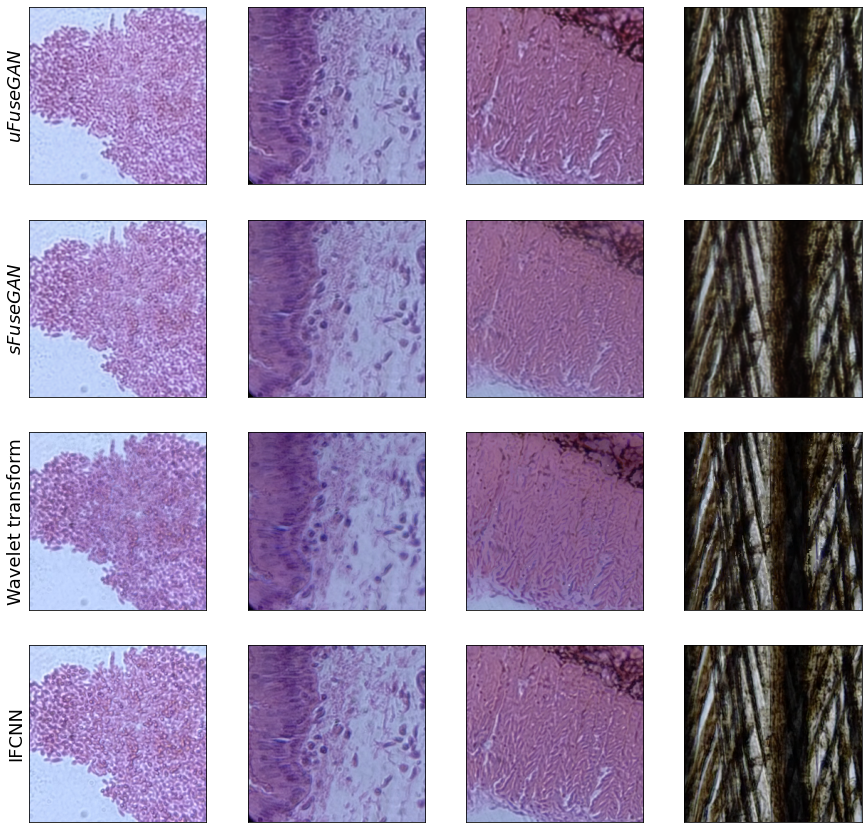

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))

### UNSUPERVISED GAN

path1 = '/content/results_gan/0.png'
img1 = PIL.Image.open(path1)
print(np.asarray(img1).shape)
ax[0,0].imshow(np.asarray(img1)[200:450, 200:450])
ax[0,0].get_xaxis().set_ticks([])
ax[0,0].get_yaxis().set_ticks([])

ax[0,0].set_ylabel(f"$uFuseGAN$",fontsize=18)

path2 = '/content/results_gan/6.png'
img2 = PIL.Image.open(path2)
print(np.asarray(img2).shape)
ax[0,1].imshow(np.asarray(img2)[350:600, 120:370])
ax[0,1].get_xaxis().set_ticks([])
ax[0,1].get_yaxis().set_ticks([])


path3 = '/content/results_gan/94.png'
img3 = PIL.Image.open(path3)
print(np.asarray(img3).shape)
ax[0,2].imshow(np.asarray(img3)[100:350, 150:400])
ax[0,2].get_xaxis().set_ticks([])
ax[0,2].get_yaxis().set_ticks([])



path4 = '/content/results_gan/98.png'
img4 = PIL.Image.open(path4)
print(np.asarray(img4).shape)
ax[0,3].imshow(np.asarray(img4)[200:450, 200:450])
ax[0,3].get_xaxis().set_ticks([])
ax[0,3].get_yaxis().set_ticks([])


### GT IMAGE

path1 = '/content/test_gt/142_gt.png'
img1 = PIL.Image.open(path1)
print(np.asarray(img1).shape)
ax[2,0].imshow(np.asarray(img1)[200:450, 200:450])
ax[2,0].get_xaxis().set_ticks([])
ax[2,0].get_yaxis().set_ticks([])

ax[2,0].set_ylabel(f"Wavelet transform",fontsize=18)

path2 = '/content/test_gt/75_gt.png'
img2 = PIL.Image.open(path2)
print(np.asarray(img2).shape)
ax[2,1].imshow(np.asarray(img2)[350:600, 120:370])
ax[2,1].get_xaxis().set_ticks([])
ax[2,1].get_yaxis().set_ticks([])


path3 = '/content/test_gt/80_gt.png'
img3 = PIL.Image.open(path3)
print(np.asarray(img3).shape)
ax[2,2].imshow(np.asarray(img3)[100:350, 150:400])
ax[2,2].get_xaxis().set_ticks([])
ax[2,2].get_yaxis().set_ticks([])


path4 = '/content/test_gt/7_gt.png'
img4 = PIL.Image.open(path4)
print(np.asarray(img4).shape)
ax[2,3].imshow(np.asarray(img4)[200:450, 200:450])
ax[2,3].get_xaxis().set_ticks([])
ax[2,3].get_yaxis().set_ticks([])

## GAN Supervised

path1 = '/content/results_gan_sup/98.png'
img1 = PIL.Image.open(path1)
print(np.asarray(img1).shape)
ax[1,0].imshow(np.asarray(img1)[200:450, 200:450])
ax[1,0].get_xaxis().set_ticks([])
ax[1,0].get_yaxis().set_ticks([])

ax[1,0].set_ylabel(f"$sFuseGAN$",fontsize=18)

path2 = '/content/results_gan_sup/6.png'
img2 = PIL.Image.open(path2)
print(np.asarray(img2).shape)
ax[1,1].imshow(np.asarray(img2)[350:600, 120:370])
ax[1,1].get_xaxis().set_ticks([])
ax[1,1].get_yaxis().set_ticks([])

path3 = '/content/results_gan_sup/0.png'
img3 = PIL.Image.open(path3)
print(np.asarray(img3).shape)
ax[1,2].imshow(np.asarray(img3)[100:350, 150:400])
ax[1,2].get_xaxis().set_ticks([])
ax[1,2].get_yaxis().set_ticks([])


path4 = '/content/results_gan_sup/94.png'
img4 = PIL.Image.open(path4)
print(np.asarray(img4).shape)
ax[1,3].imshow(np.asarray(img4)[200:450, 200:450])
ax[1,3].get_xaxis().set_ticks([])
ax[1,3].get_yaxis().set_ticks([])

## IFCNN

path1 = '/content/content/results_max/IFCNN-MAX-142.png'
img1 = PIL.Image.open(path1)
print(np.asarray(img1).shape)
ax[3,0].imshow(np.asarray(img1)[200:450, 200:450])
ax[3,0].get_xaxis().set_ticks([])
ax[3,0].get_yaxis().set_ticks([])

ax[3,0].set_ylabel(f"IFCNN",fontsize=18)

path2 = '/content/content/results_max/IFCNN-MAX-75.png'
img2 = PIL.Image.open(path2)
print(np.asarray(img2).shape)
ax[3,1].imshow(np.asarray(img2)[350:600, 120:370])
ax[3,1].get_xaxis().set_ticks([])
ax[3,1].get_yaxis().set_ticks([])


path3 = '/content/content/results_max/IFCNN-MAX-80.png'
img3 = PIL.Image.open(path3)
print(np.asarray(img3).shape)
ax[3,2].imshow(np.asarray(img3)[100:350, 150:400])
ax[3,2].get_xaxis().set_ticks([])
ax[3,2].get_yaxis().set_ticks([])


path4 = '/content/content/results_max/IFCNN-MAX-7.png'
img4 = PIL.Image.open(path4)
print(np.asarray(img4).shape)
ax[3,3].imshow(np.asarray(img4)[200:450, 200:450])
ax[3,3].get_xaxis().set_ticks([])
ax[3,3].get_yaxis().set_ticks([])

# Metric calculations

CNNIQA metric


In [0]:
!git clone https://github.com/lidq92/CNNIQA

Cloning into 'CNNIQA'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 4.61 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [0]:
from argparse import ArgumentParser
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from CNNIQA.IQADataset import NonOverlappingCropPatches


class CNNIQAnet(nn.Module):
    def __init__(self, ker_size=7, n_kers=50, n1_nodes=800, n2_nodes=800):
        super(CNNIQAnet, self).__init__()
        self.conv1  = nn.Conv2d(1, n_kers, ker_size)
        self.fc1    = nn.Linear(2 * n_kers, n1_nodes)
        self.fc2    = nn.Linear(n1_nodes, n2_nodes)
        self.fc3    = nn.Linear(n2_nodes, 1)

    def forward(self, x):
        x  = x.view(-1, x.size(-3), x.size(-2), x.size(-1))  #

        h  = self.conv1(x)

        # h1 = F.adaptive_max_pool2d(h, 1)
        # h2 = -F.adaptive_max_pool2d(-h, 1)
        h1 = F.max_pool2d(h, (h.size(-2), h.size(-1)))
        h2 = -F.max_pool2d(-h, (h.size(-2), h.size(-1)))
        h  = torch.cat((h1, h2), 1)  # max-min pooling
        h  = h.squeeze(3).squeeze(2)

        h  = F.relu(self.fc1(h))
        h  = F.dropout(h)
        h  = F.relu(self.fc2(h))

        q  = self.fc3(h)
        return q

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNIQAnet(ker_size=7,
                  n_kers=50,
                  n1_nodes=800,
                  n2_nodes=800).to(device)

model.load_state_dict(torch.load('/content/CNNIQA/models/CNNIQA-LIVE'))

<All keys matched successfully>

In [0]:
def get_score(model, img_path):
    im = Image.open(img_path).convert('L')
    patches = NonOverlappingCropPatches(im, 32, 32)

    model.eval()
    with torch.no_grad():
        patch_scores = model(torch.stack(patches).to(device))
        # print(patch_scores.mean().item())

    return patch_scores.mean().item()

In [0]:
score_cnn_img = get_score(model, f'/content/results_gan/1.png')
score_alg_img = get_score(model, f'/content/test_gt/80_gt.png')

In [0]:
score_cnn_img = get_score(model, f'/content/results_gan/2.png')
score_alg_img = get_score(model, f'/content/test_data/75_2.png')

BRISQUE metric

In [0]:
pip install image-quality

     |████████████████████████████████| 153kB 6.2MB/s 
     |████████████████████████████████| 174kB 12.0MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233332 sha256=20319236177b642f4629b87fb204e8590853b662b0e4766dca72f615507a65ed
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm


In [0]:
import imquality.brisque as brisque
import PIL.Image

path = '/content/results_gan/2.png'
img = PIL.Image.open(path)
brisque.score(img)

In [0]:
path = '/content/test_data/75_2.png'
img = PIL.Image.open(path)
brisque.score(img)